# Barycenter Experiment


## imports and misc

In [2]:
from pathlib import Path
if "experiments" in Path.cwd().parts:
    %cd ..

import logging
import os
import sys
import warnings
import itertools as it
from time import perf_counter
def append_path(s):
    if s in sys.path:
        return
    sys.path.insert(0, s)
    
#You don’t need those lines if you installed the packages
#append_path("/home/tristan/research/ot_markov_distances/")
#append_path("/home/tristan/research/tb_ml/")
    
#sys.path.pop(sys.path.index("/home/tristan/research/ot_markov_distances/experiments"))

logging.basicConfig(level=logging.INFO, force=True)

/home/tristan/research/ot_markov_distances


/home/tristan/.cache/pypoetry/virtualenvs/ot-markov-distances-l3BjNOj2-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
import scipy
import scipy.sparse


In [4]:
from skimage.filters import threshold_otsu, threshold_yen

In [5]:
from ot_markov_distances import discounted_wl_infty as wl_reg_infty
from ot_markov_distances.utils import weighted_transition_matrix, draw_markov
from experiments.utils.modules import ParametricMarkovMatrixWithMatchings, ParametricMarkovMatrix, ParametricMarkovMatrixWithLabels
from experiments.utils.data_generation import get_oriented_circle,gen_noisy_oriented_circles, circle_graph, FGW_build_noisy_circular_graph, add_er_noise, get_label_matrix
from experiments.utils import grid_init, my_threshold, markov_threshold
from experiments.utils.optimization_loop import opt_loop_batched

%load_ext autoreload
%autoreload 2

In [6]:
#this was not properly packaged so you cannot install it
append_path("/home/tristan/research/FGW/lib")
from FGW import fgw_barycenters
from graph import Graph as FGW_Graph, graph_colors,draw_rel,draw_transp,find_thresh,sp_to_adjency


In [7]:
logging.basicConfig(level=logging.WARNING, force=True)

## Non-oriented circles

### Data

generate the data and show some examples

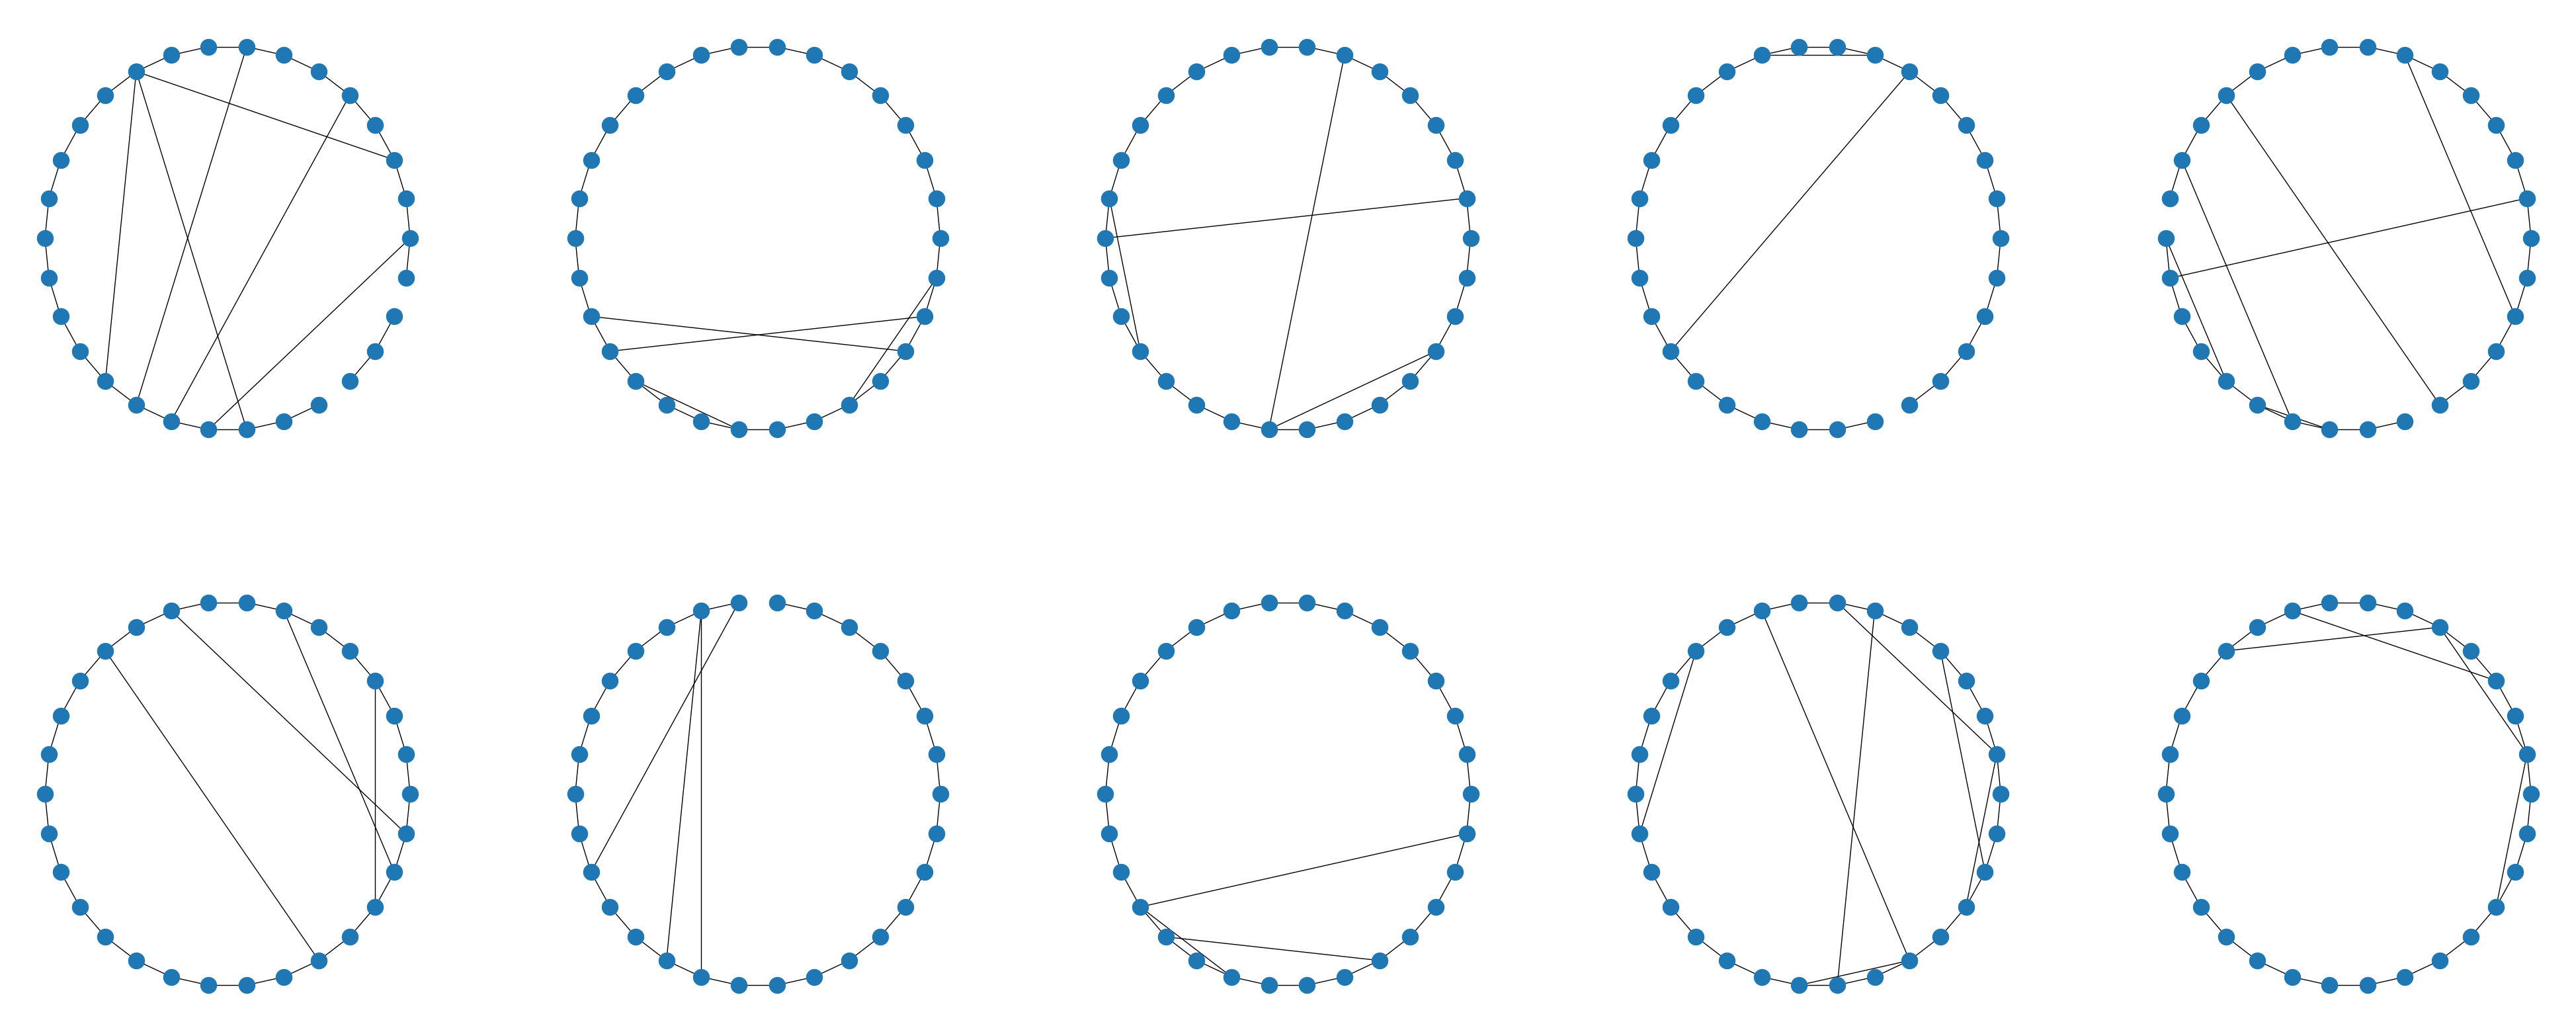

In [7]:
data_type = "ER_noise_circles"
target_size = 30
n_targets = 10

def get_data(target_size, n_targets, data_type, er_p=.01):
    target_sizes= [target_size] * n_targets
    match data_type:
        case "sampled_circles":
            target_graphs = [circle_graph(size, kind="distance") for size in target_sizes]
            original_positions = np.asarray(list(nx.get_node_attributes(target_graphs[0], "pos").values()))
            target_labels = None
        case "ER_noise_circles":
            target_graphs = [add_er_noise(FGW_build_noisy_circular_graph(size, sigma=0), p=er_p) for size in target_sizes]
            target_labels = [get_label_matrix(g) for g in target_graphs]
            original_positions = None
    target_matrices = [weighted_transition_matrix(g, q=0) for g in target_graphs]
    return target_graphs, original_positions, target_labels, target_matrices

target_graphs, original_positions, target_labels, target_matrices = get_data(target_size, n_targets, data_type)
        
_, axes = plt.subplots(n_targets // 5, 5 , figsize=(50, 10 * (n_targets // 5) ))
for G, ax in zip(target_graphs, axes.flat):
    nx.draw(G, pos=nx.get_node_attributes(G, "pos"), ax=ax)


### Grid Search

Here we show barycenters with different noise parameters and number of target graphs, using our method

In [95]:
projection_size = target_size = 20
noise_values = [0, .001, .005, .01, .1]
n_target_parameters = [1, 5, 10, 20, 30, 50]

if "projection_grid" not in vars():
    projection_grid = grid_init(len(noise_values), len(n_target_parameters))


In [ ]:
for (noise_index, noise), (n_target_index, n_target) in \
    it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    target_graphs, original_positions, target_labels, target_matrices = get_data(target_size, n_target, data_type,
                                                                   er_p=noise)
    if projection_grid[noise_index][n_target_index] is not None:
        continue
    projection, parameter_values, losses = opt_loop_batched(
        target_matrices, 
        projection_size=projection_size,
        n_steps=500,
        heat=1,
        lr=5e-3,
        weight_decay=0,
        run_name=f"{data_type} - barycenter{projection_size} - {(run_number:=vars().get('run_number', 0)+1)}",
        labels=target_labels
    )
    
    projection_grid[noise_index][n_target_index] = projection.cpu()
    
    %store projection_grid

projection.draw(original_positions)

In [ ]:
_, axes = plt.subplots(len(noise_values), len(n_target_parameters), figsize =(len(noise_values)*5, len(n_target_parameters)*5))

for (i, noise), (j, n_targets) in it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    if projection_grid[i][j] is None:
        continue
    projection_grid[i][j].draw(ax=axes[i,j])
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


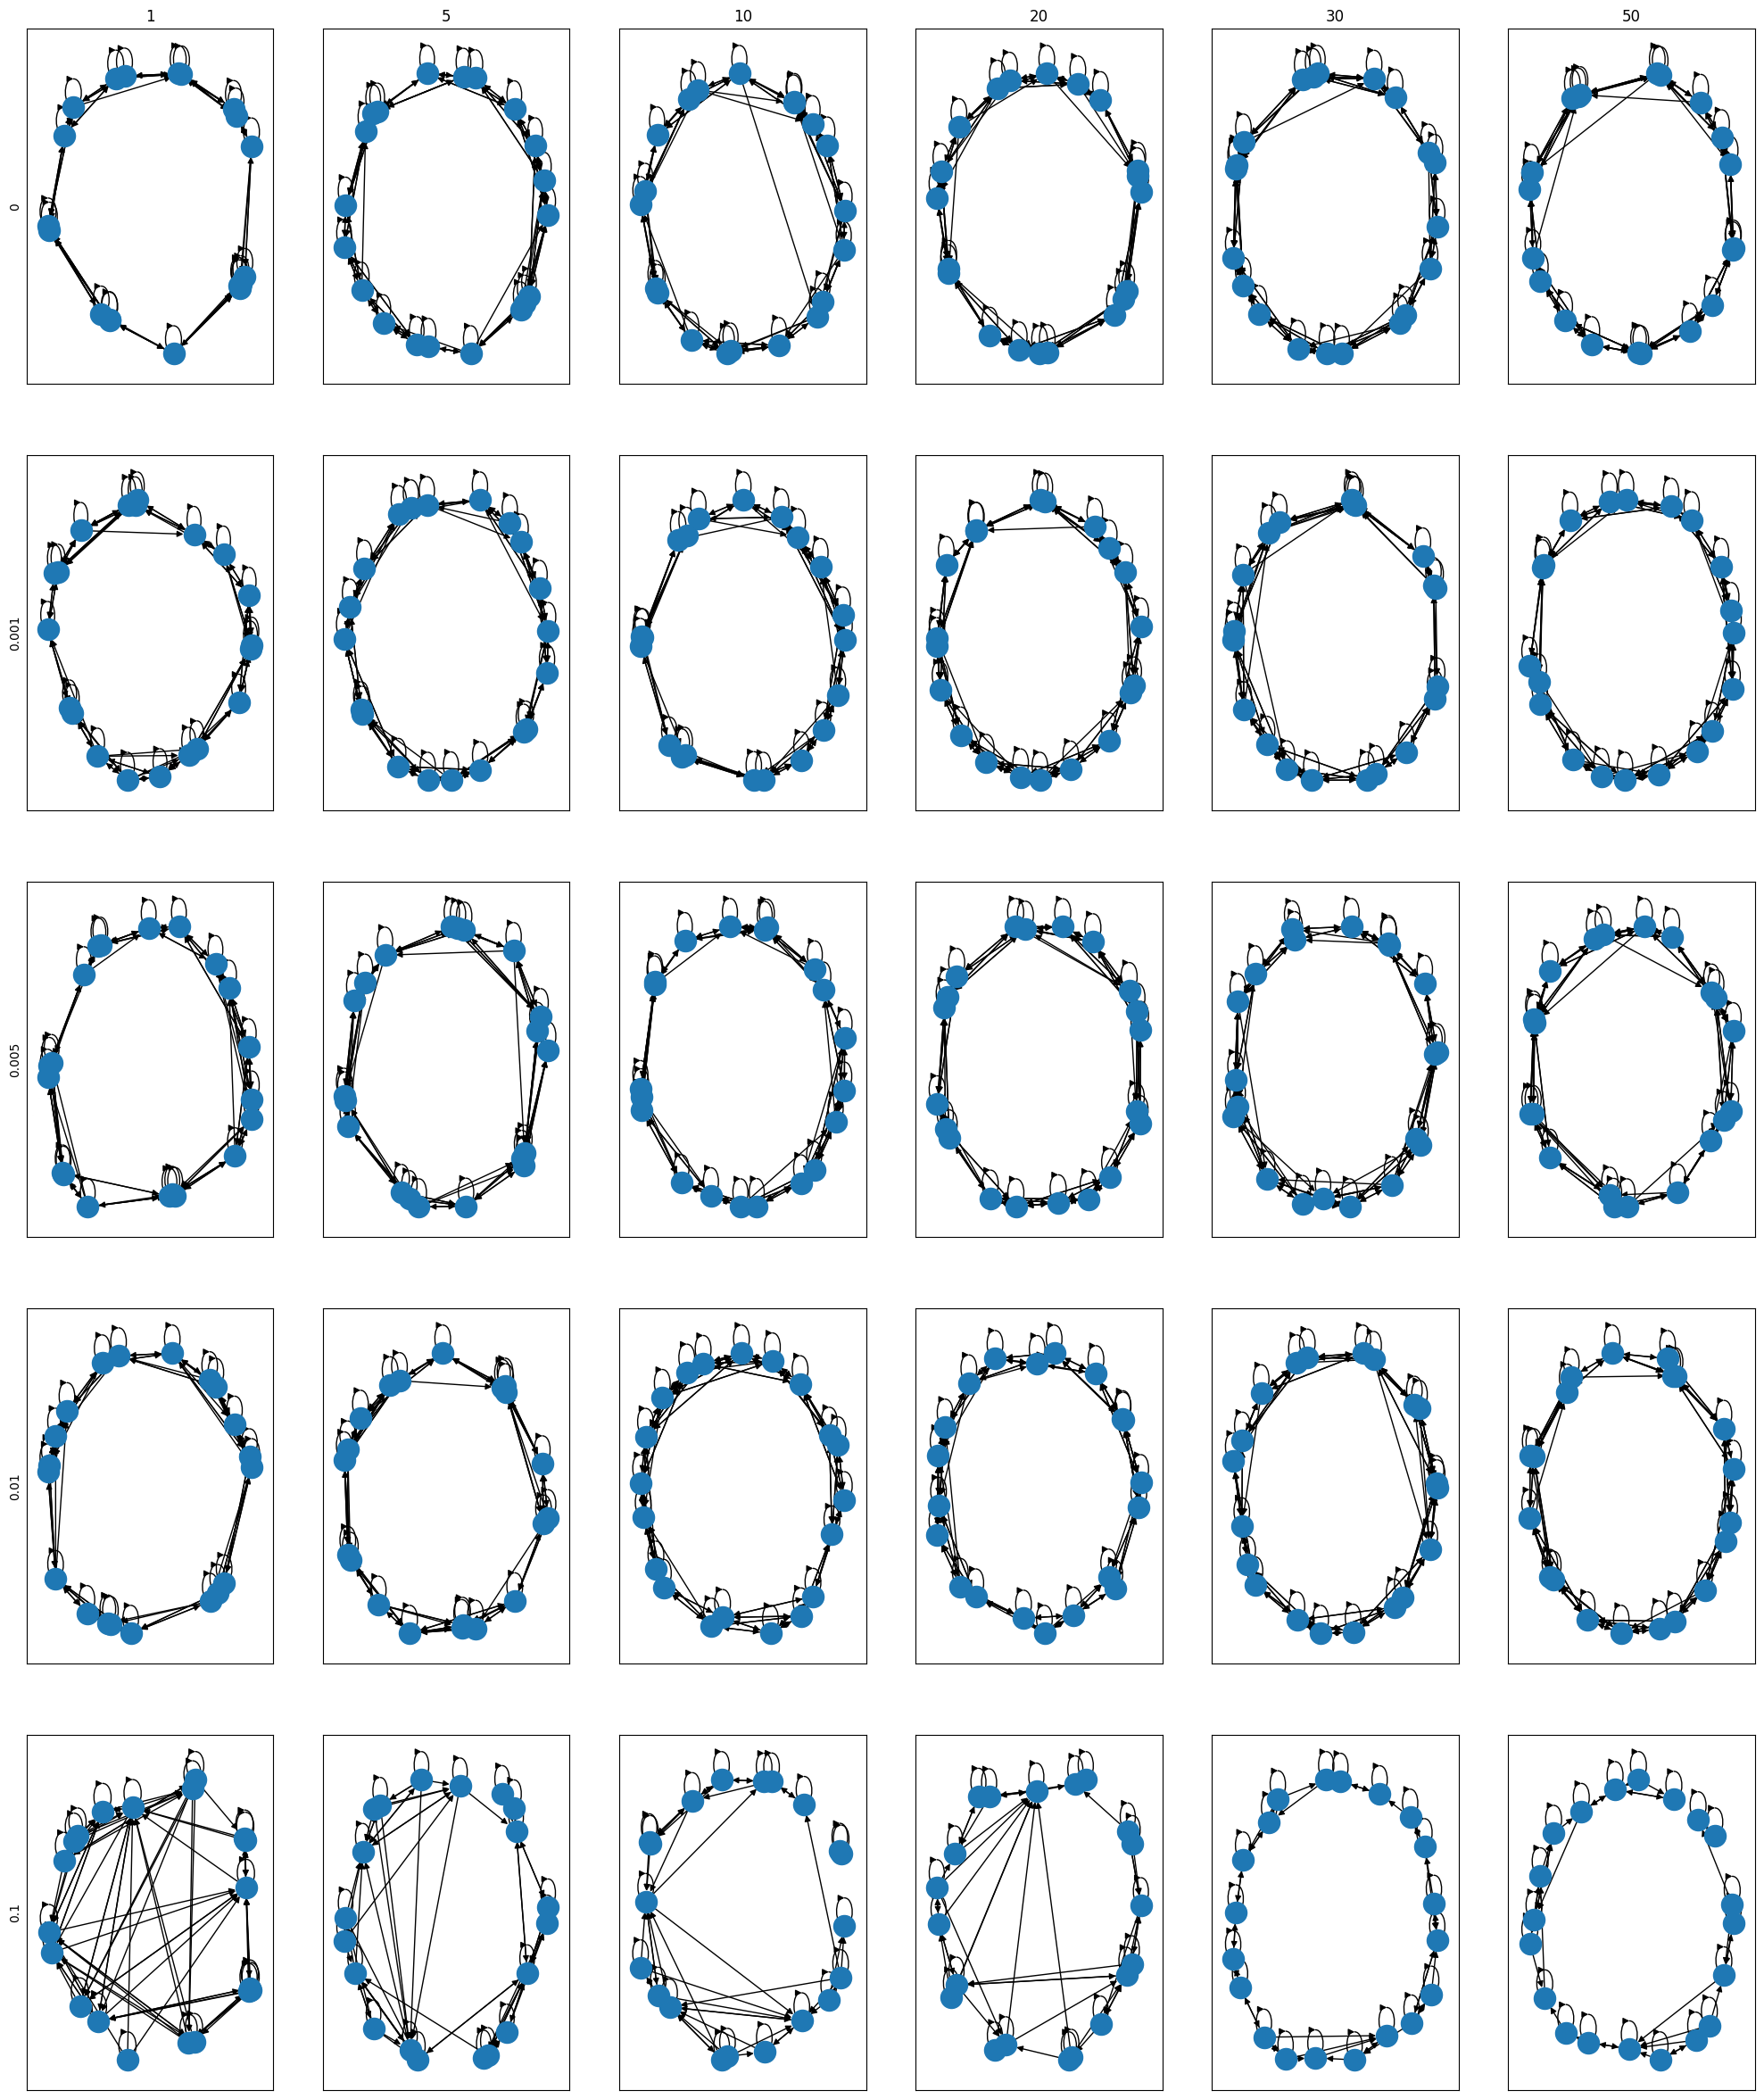

In [256]:
_, axes = plt.subplots(len(noise_values), len(n_target_parameters), figsize =(len(noise_values)*5, len(n_target_parameters)*5))

for (i, noise), (j, n_targets) in it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    markov, labels = projection_grid[i][j].get()
    G = markov_threshold(markov.numpy(force=True))
    pos = {i: l.numpy(force=True) for i, l in enumerate(labels)}
    nx.draw(G, pos, ax=axes[i, j])
    axes[i, j].set_axis_on()
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


### FGW

Here we show barycenters with different noise parameters and number of target graphs, using FGW

In [45]:
sizebary = projection_size = target_size = 20
noise_values = [0, .001, .005, .01, .1]
n_target_parameters = [1, 5, 10, 20, 30, 50]



In [46]:
def rename_attribute(G ,attr1="attr", attr2="attr_name"):
    for node, data in G.nodes(data=True):
        data[attr2] = data[attr1]
        
def to_fgw_graph(G):
    rename_attribute(G)
    return FGW_Graph(G)
to_fgw_graph(target_graphs[0])

In [47]:
from ml_lib.misc import debug_time
from time import perf_counter
logging.basicConfig(level= logging.WARN, force=True)

In [ ]:
fgw_projection_grid = grid_init(len(noise_values), len(n_target_parameters))
times = []
for (noise_index, noise), (n_target_index, n_target) in \
    it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    target_graphs, original_positions, target_labels, target_matrices = get_data(target_size, n_target, data_type,
                                                                   er_p=noise)
    FGW_graphs = [to_fgw_graph(i) for i in target_graphs]
    if fgw_projection_grid[noise_index][n_target_index] is not None:
        continue
    X0 = FGW_graphs
    Cs=[x.distance_matrix(force_recompute=True,method='shortest_path') for x in X0]
    ps=[np.ones(len(x.nodes()))/len(x.nodes()) for x in X0]
    Ys=[x.values() for x in X0]
    lambdas=np.array([np.ones(len(Ys))/len(Ys)]).ravel()
    init_X=np.random.rand(projection_size,2)
    t0 = perf_counter()
    D1,C1,log=fgw_barycenters(sizebary,Ys,Cs,ps,lambdas,alpha=0.95,init_X=init_X)
    t1 = perf_counter()
    times.append(t1 - t0)
    bary=nx.from_numpy_array(sp_to_adjency(C1,threshinf=0,threshsup=find_thresh(C1,sup=100,step=100)[0]))
    for i in range(len(D1)):
        bary.add_node(i, pos=D1[i])
    fgw_projection_grid[noise_index][n_target_index] = bary
    
    %store fgw_projection_grid


In [67]:
np.mean(times), np.max(times), np.min(times)

(0.6699159354281922, 4.159470901824534, 0.005218181759119034)

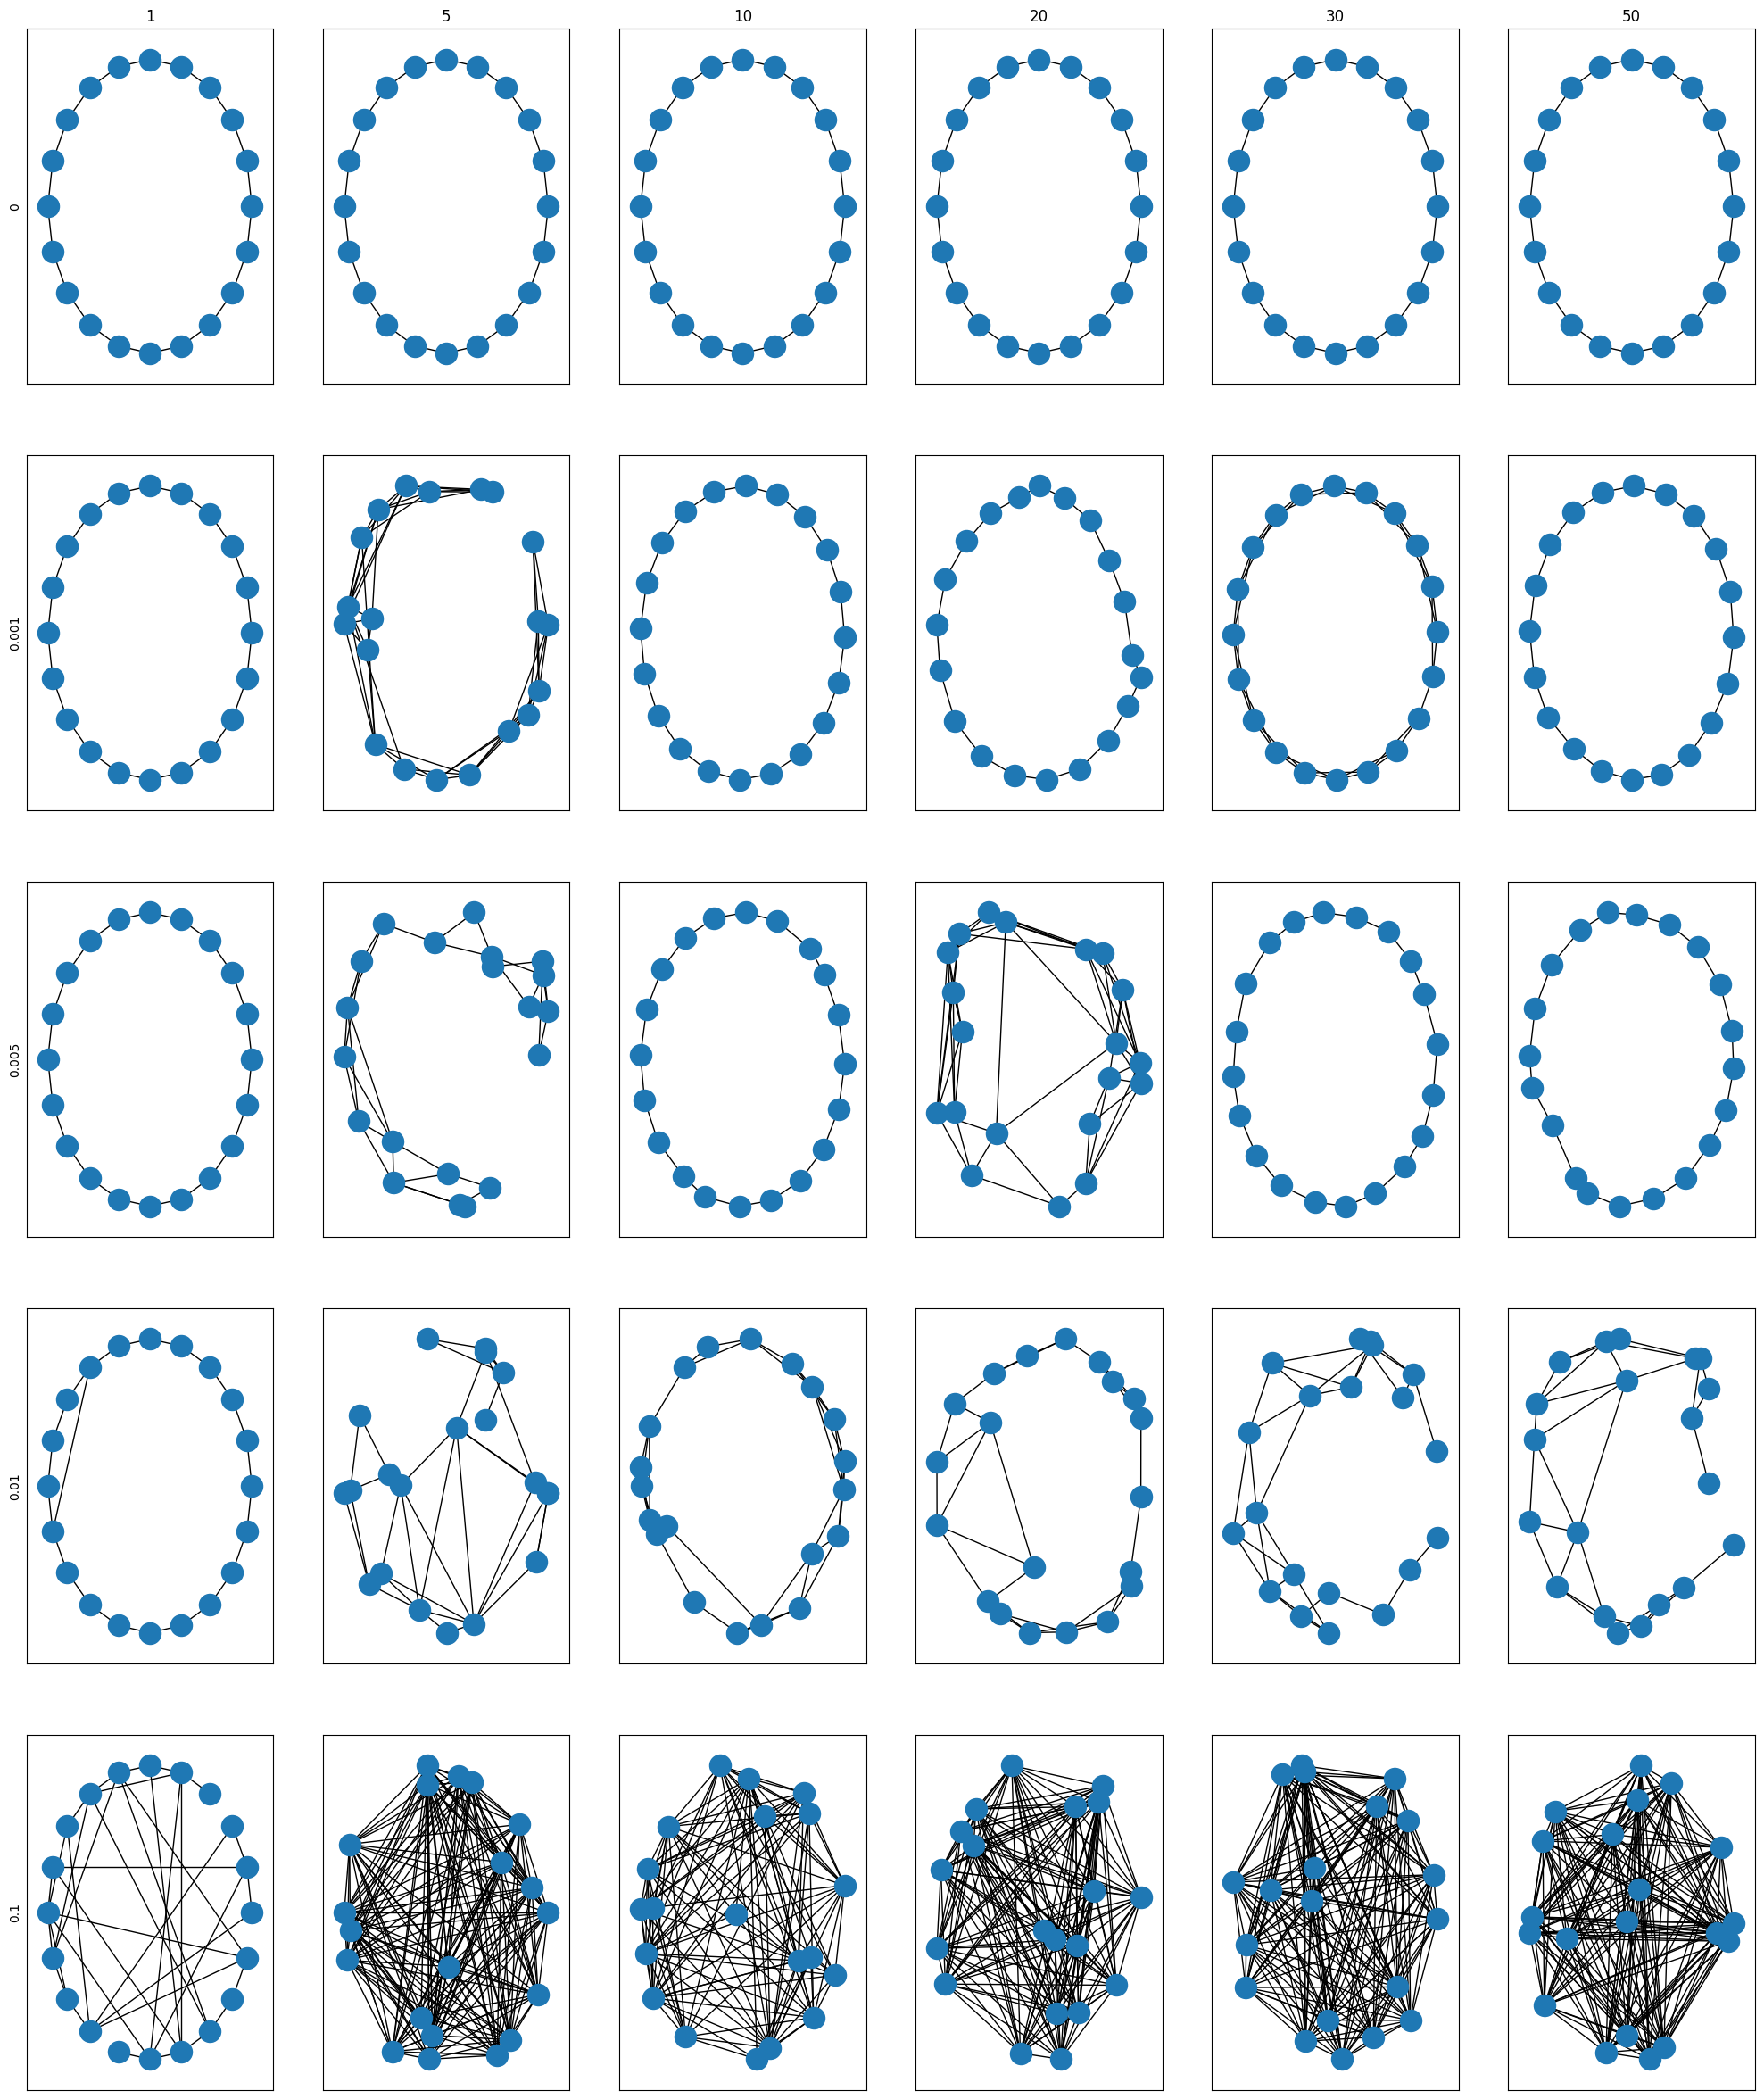

In [67]:
_, axes = plt.subplots(len(noise_values), len(n_target_parameters), figsize =(len(noise_values)*5, len(n_target_parameters)*5))

for (i, noise), (j, n_targets) in it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    G = fgw_projection_grid[i][j]
    pos = nx.get_node_attributes(G, "pos")
    nx.draw(G, pos, ax=axes[i, j])
    axes[i, j].set_axis_on()
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


### Single FGW Graph

Here we isolate a set of parameters that show a result representative of how FGW can fail on this problem

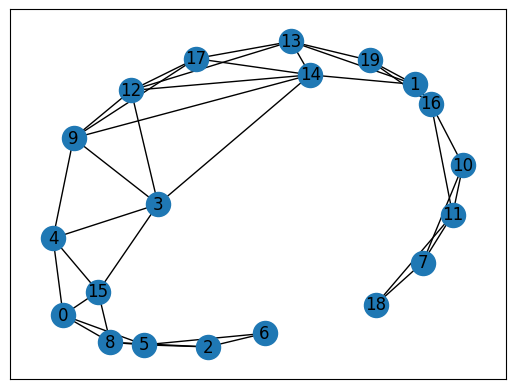

In [56]:
target_size = 20
n_target=20
noise = 0.01

target_graphs, original_positions, target_labels, target_matrices = get_data(target_size, n_target, data_type,
                                                               er_p=noise)
FGW_graphs = [to_fgw_graph(i) for i in target_graphs]
X0 = FGW_graphs
Cs=[x.distance_matrix(force_recompute=True,method='shortest_path') for x in X0]
ps=[np.ones(len(x.nodes()))/len(x.nodes()) for x in X0]
Ys=[x.values() for x in X0]
lambdas=np.array([np.ones(len(Ys))/len(Ys)]).ravel()
init_X=np.random.rand(projection_size,2)
D1,C1,log=fgw_barycenters(sizebary,Ys,Cs,ps,lambdas,alpha=0.95,init_X=init_X)
bary=nx.from_numpy_array(sp_to_adjency(C1,threshinf=0,threshsup=find_thresh(C1,sup=100,step=100)[0]))
for i in range(len(D1)):
    bary.add_node(i, pos=D1[i])
    
pos = nx.get_node_attributes(bary, "pos")
nx.draw_networkx(bary, pos)


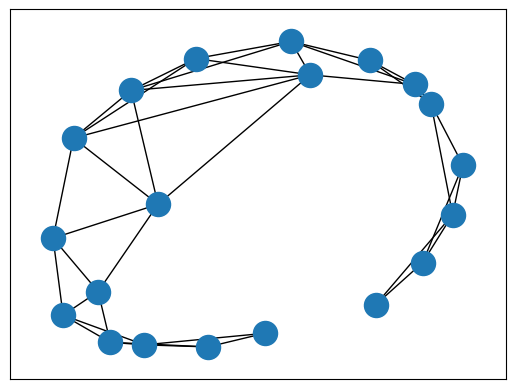

In [57]:
nx.draw_networkx(bary, pos, with_labels=False)


## Directed Graphs

Now we also compute barycenters using directed circles (with our method only, since the original FGW does not support directed graphs)

### Data

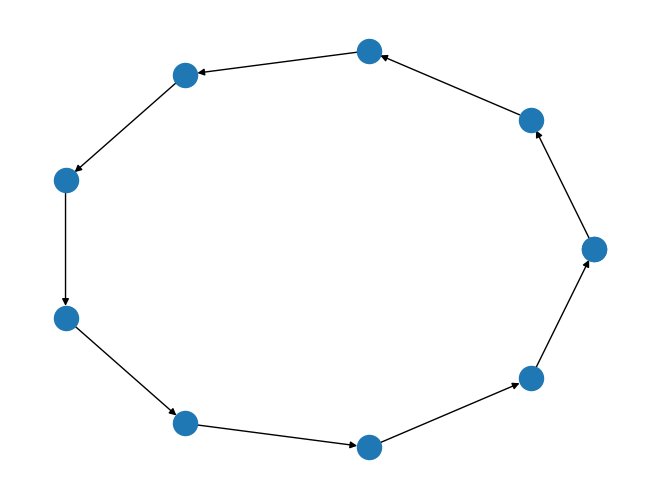

In [12]:
G = get_oriented_circle(10, doubled_edges=1)
nx.draw(G, nx.get_node_attributes(G, "pos"))

## oriented circles

### Data

In [8]:
bary_size = target_size = 20
n_targets = 50
er_p = .01
#doubled_edges= 2
doubled_edges= 1

graphs, target_markovs, distributions, target_labels = gen_noisy_oriented_circles(n_targets, target_size, er_p, doubled_edges=doubled_edges)
    

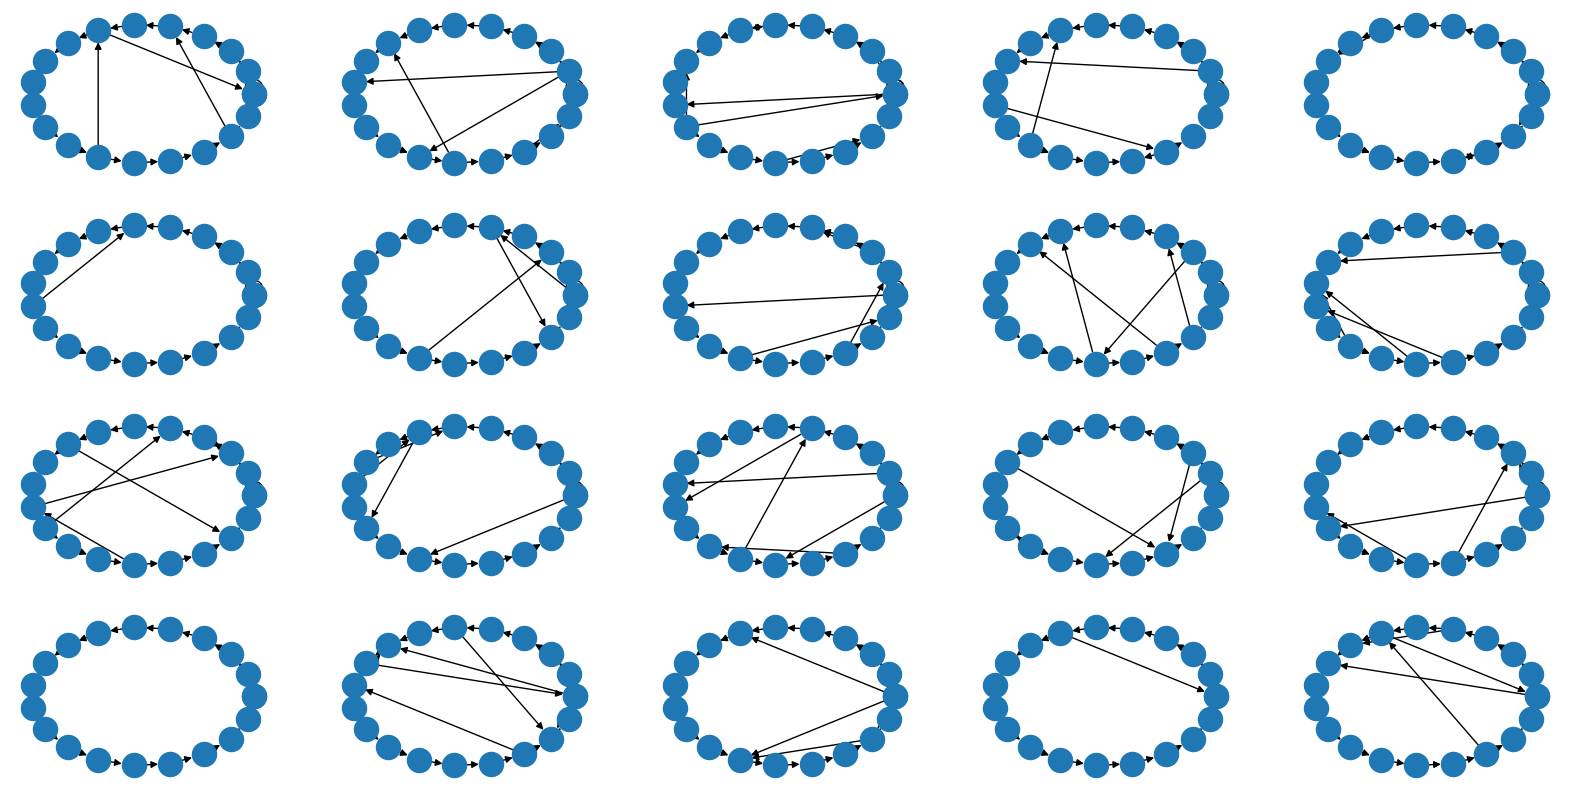

In [9]:
_, axes = plt.subplots(4, 5, figsize=(20, 10))
    
for ax, graph in zip(axes.flat, graphs):
    plt.sca(ax)
    nx.draw(graph, nx.get_node_attributes(graph, "pos"))

And here is an example depending on the amount of noise

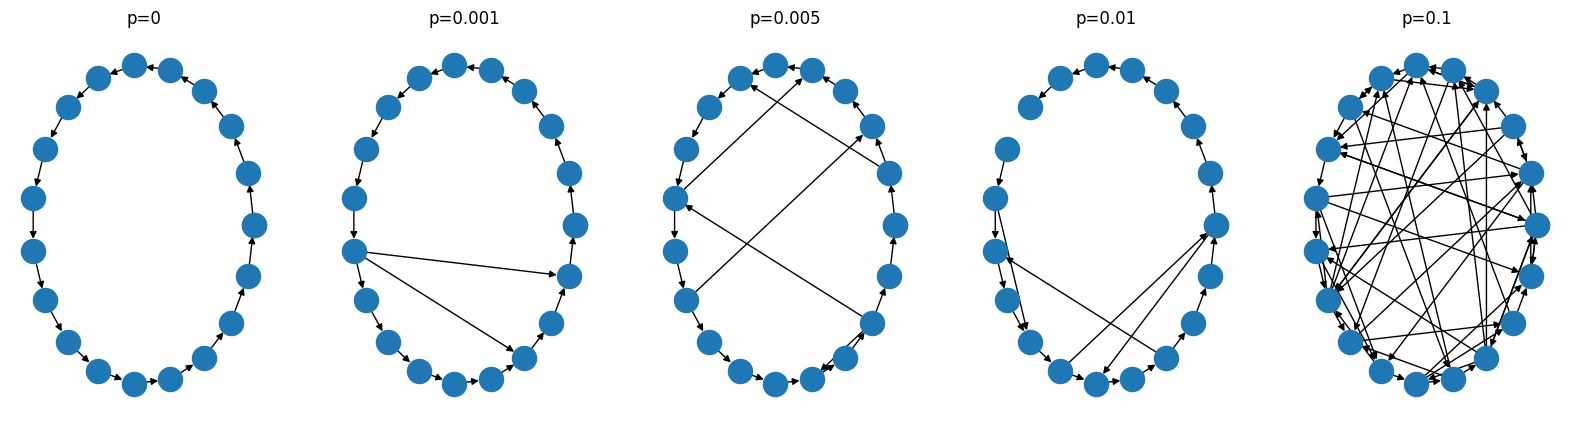

In [141]:
_, axes = plt.subplots(1, len(noise_values), figsize=(20, 5))
    
for ax, noise in zip(axes.flat, noise_values):
    (graph,), _, _, _ = gen_noisy_oriented_circles(1, target_size, er_p=noise, doubled_edges=doubled_edges)
    plt.sca(ax)
    plt.title(f"p={noise}")
    nx.draw(graph, nx.get_node_attributes(graph, "pos"))
    

### Basic barycenter computation

Now let's compute the barycenter of those graphs

In [11]:
bary, parameter_values, losses = opt_loop_batched(
        target_markovs,
        projection_size=target_size,
        device=device,
        n_steps=3000,
        heat=1,
        lr=1e-3,
        weight_decay=0,
        run_name=f"noisy_oriented_circles - barycenter{target_size} - {(run_number:=vars().get('run_number', 0)+1)}",
        labels=target_labels,
        wl_parameters = dict(sinkhorn_reg=.02, delta=.5, x_is_sparse=False, y_is_sparse=True),
    )


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/tristan/research/ot_markov_distances/ot_markov_distances/discounted_wl.py:210: UserWarning: regularized WL did not converge
  warnings.warn("regularized WL did not converge")


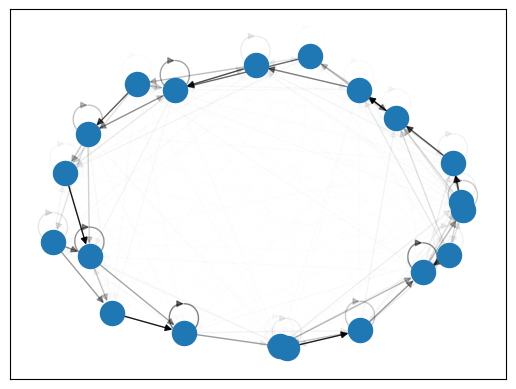

In [13]:
bary.draw()
#plt.gca().tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

And threshold (methods are `my_threshold`, `threshold_yen` and `threshold_otsu`)

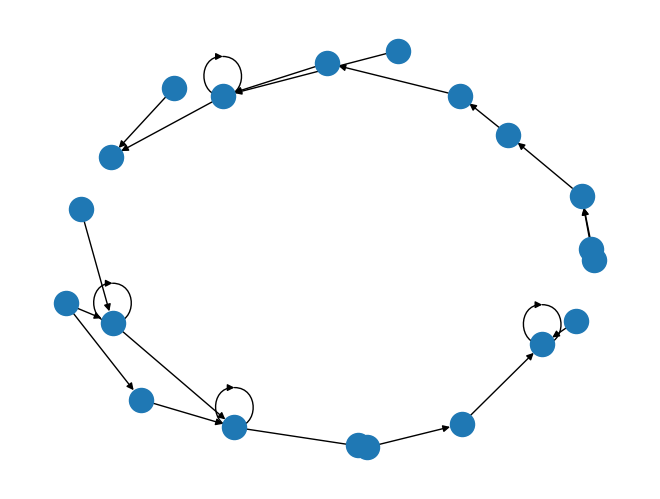

In [12]:
markov, labels = bary.get()
G = markov_threshold(markov.numpy(force=True), method=threshold_otsu)
pos = {i: l.numpy(force=True) for i, l in enumerate(labels)}
nx.draw(G, pos)


In [19]:
projection_size = target_size = 20
noise_values = [0, .001, .005, .01, .1]
n_target_parameters = [1, 5, 10, 20, 30, 40]
oriented_grid = grid_init(len(noise_values), len(n_target_parameters))
data_type = "oriented_circle"

In [20]:
#%store -r oriented_grid
for (noise_i, noise), (target_i, n_targets) in tqdm(it.product(enumerate(noise_values), enumerate(n_target_parameters)), total=len(noise_values)*len(n_target_parameters)):
    if oriented_grid[noise_i][target_i] is not None:
        continue
    
    graphs, target_markovs, distributions, target_labels = gen_noisy_oriented_circles(
        n_targets, target_size, noise, doubled_edges=doubled_edges)

    projection, parameter_values, losses = opt_loop_batched(
        target_matrices = target_markovs, 
        projection_size=projection_size,
        n_steps=3000,
        heat=1,
        lr=5e-3,
        weight_decay=0,
        run_name=f"{data_type} - barycenter2 {projection_size}-{noise}",
        labels=target_labels,
        wl_parameters = dict(sinkhorn_reg=.1, delta=.5, x_is_sparse=False, y_is_sparse=True),
        device = torch.device("cuda:2"), 
    )
    oriented_grid[noise_i][target_i] = projection
    #%store oriented_grid
    

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### `n_examples` - `noise` Grid 

Like before, we show a grid of results for different parameters

doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff


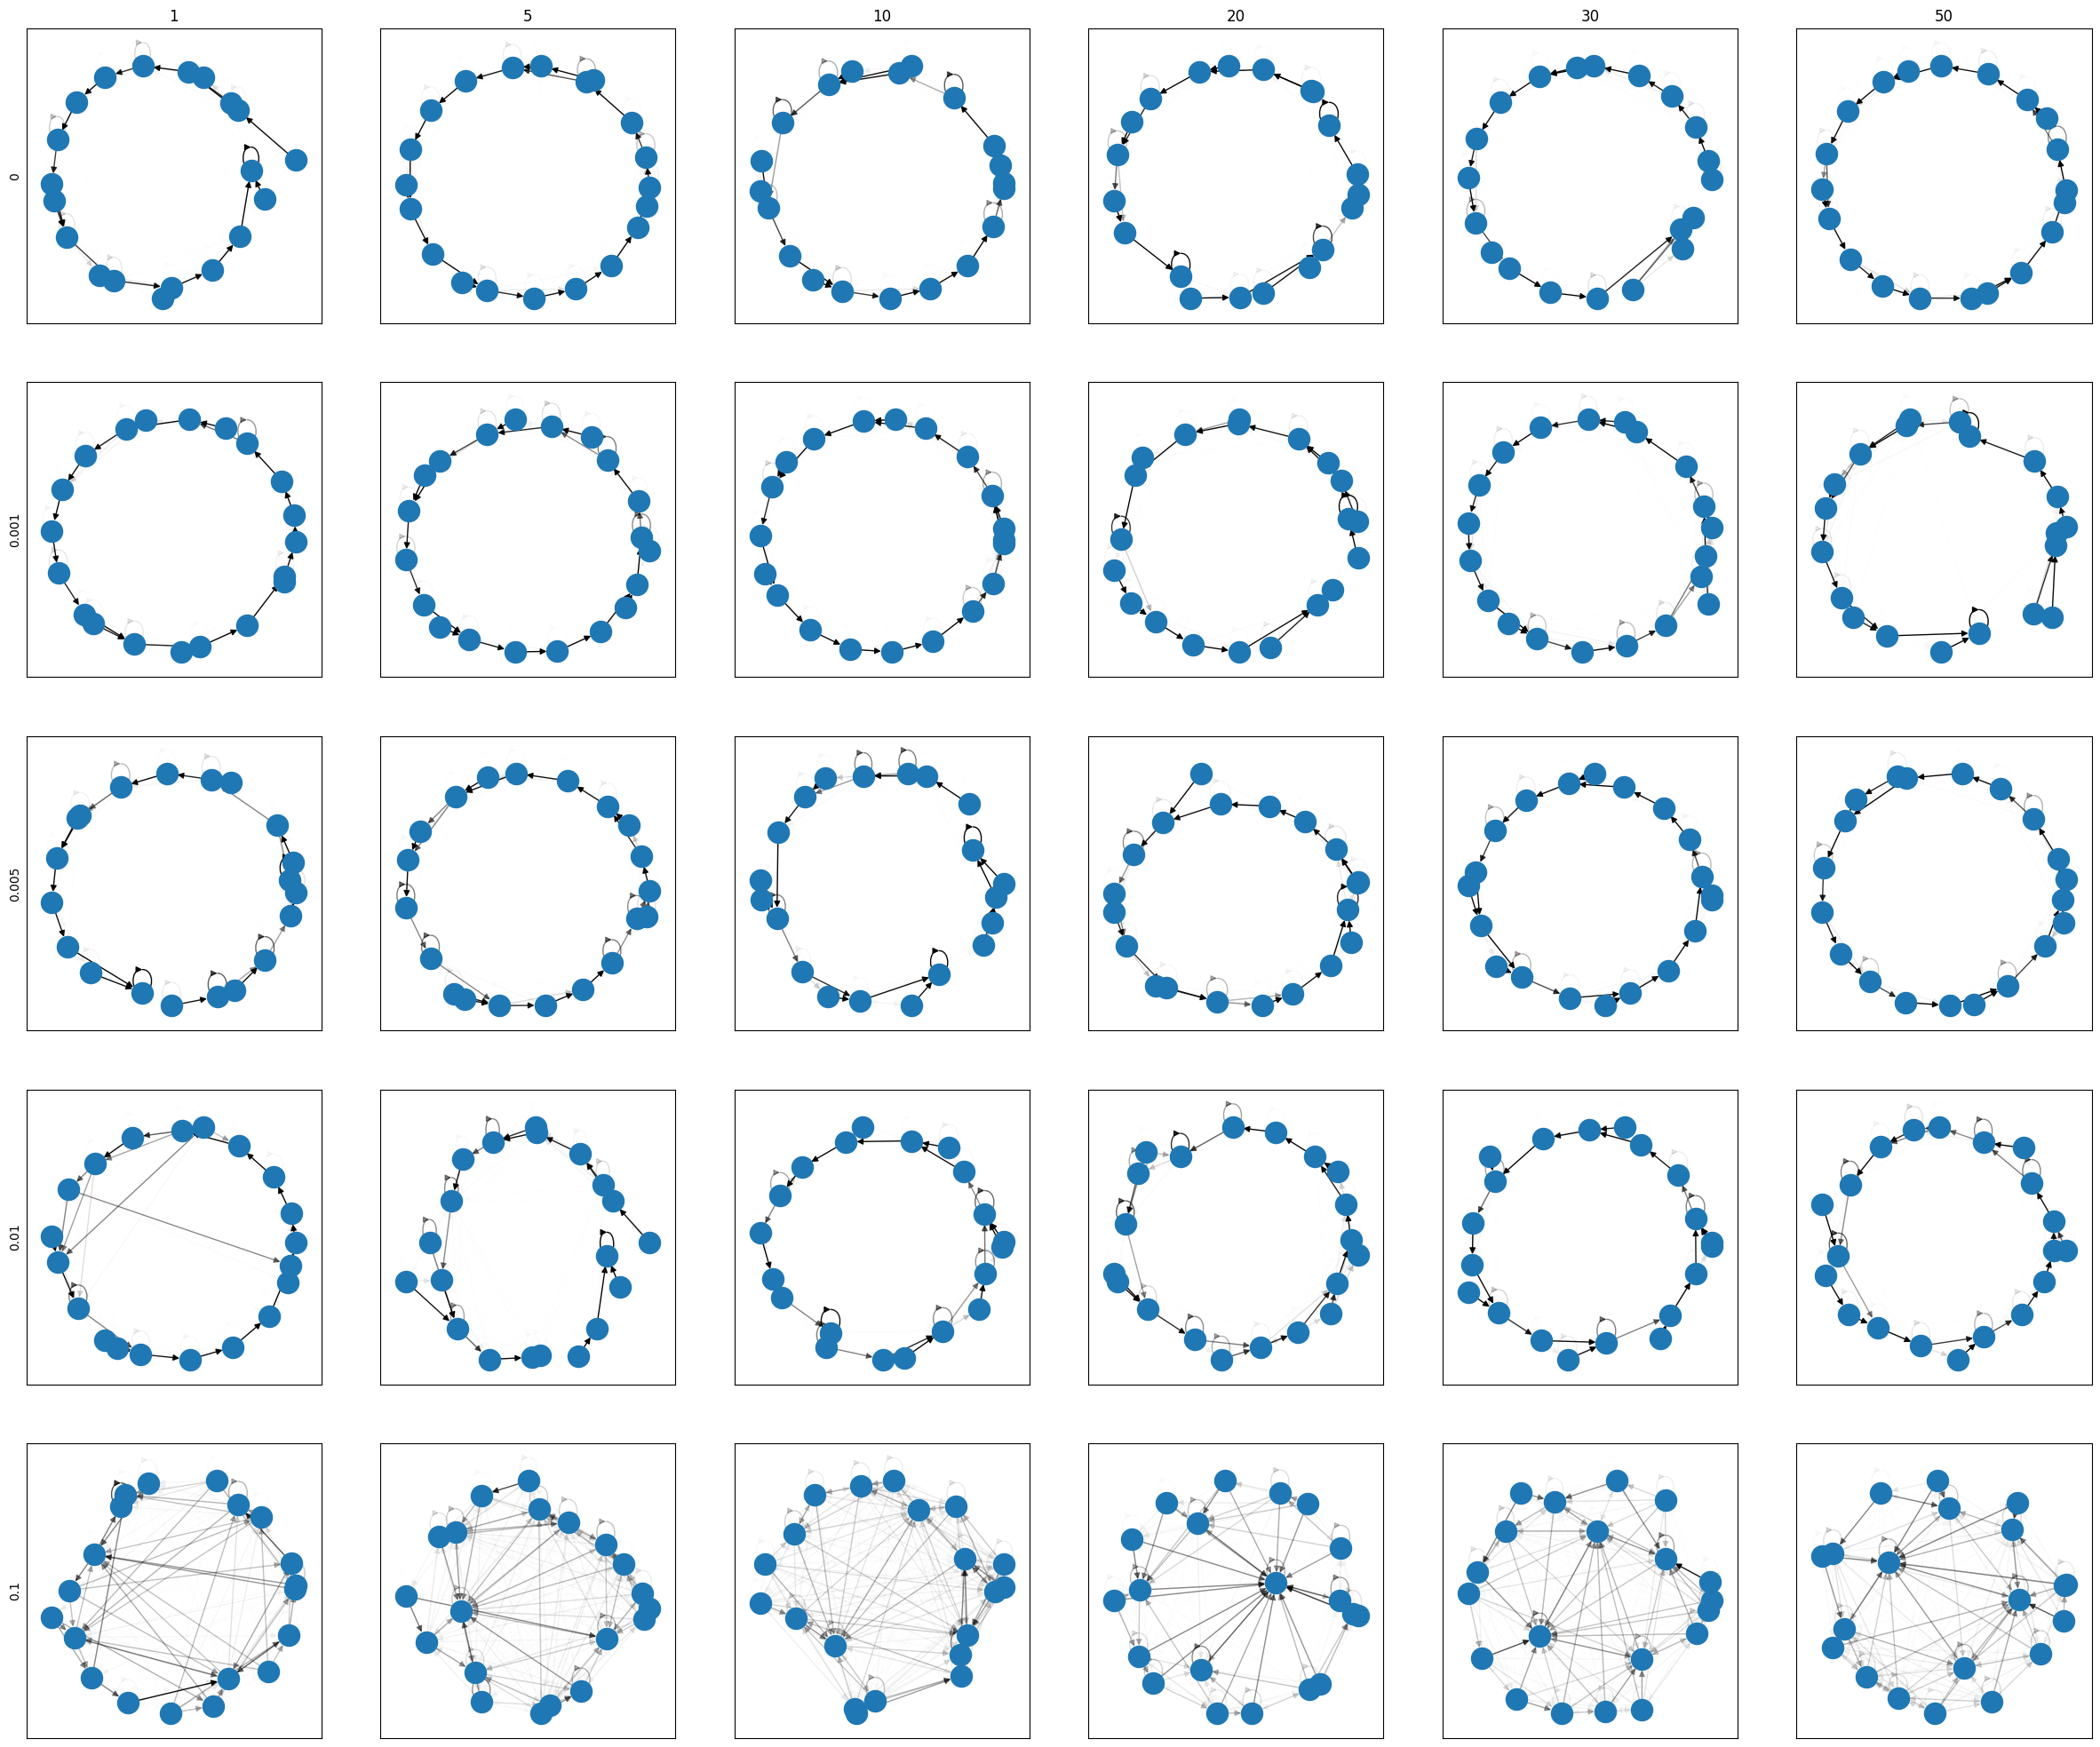

In [114]:
do_threshold=False

n_x = len(noise_values)
n_y = len(n_target_parameters)

_, axes = plt.subplots(n_x, n_y, figsize =(n_y*5, n_x*5))



for (i, noise), (j, n_targets) in it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    G = oriented_grid[i][j]
    if do_threshold:    
        markov, labels = G.get()
        G = markov_threshold(markov.numpy(force=True))
        pos = {i: l.numpy(force=True) for i, l in enumerate(labels)}
        nx.draw(G, pos, ax=axes[i, j])
    else:     
        G.draw(ax=axes[i,j])
    axes[i, j].set_axis_on()
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


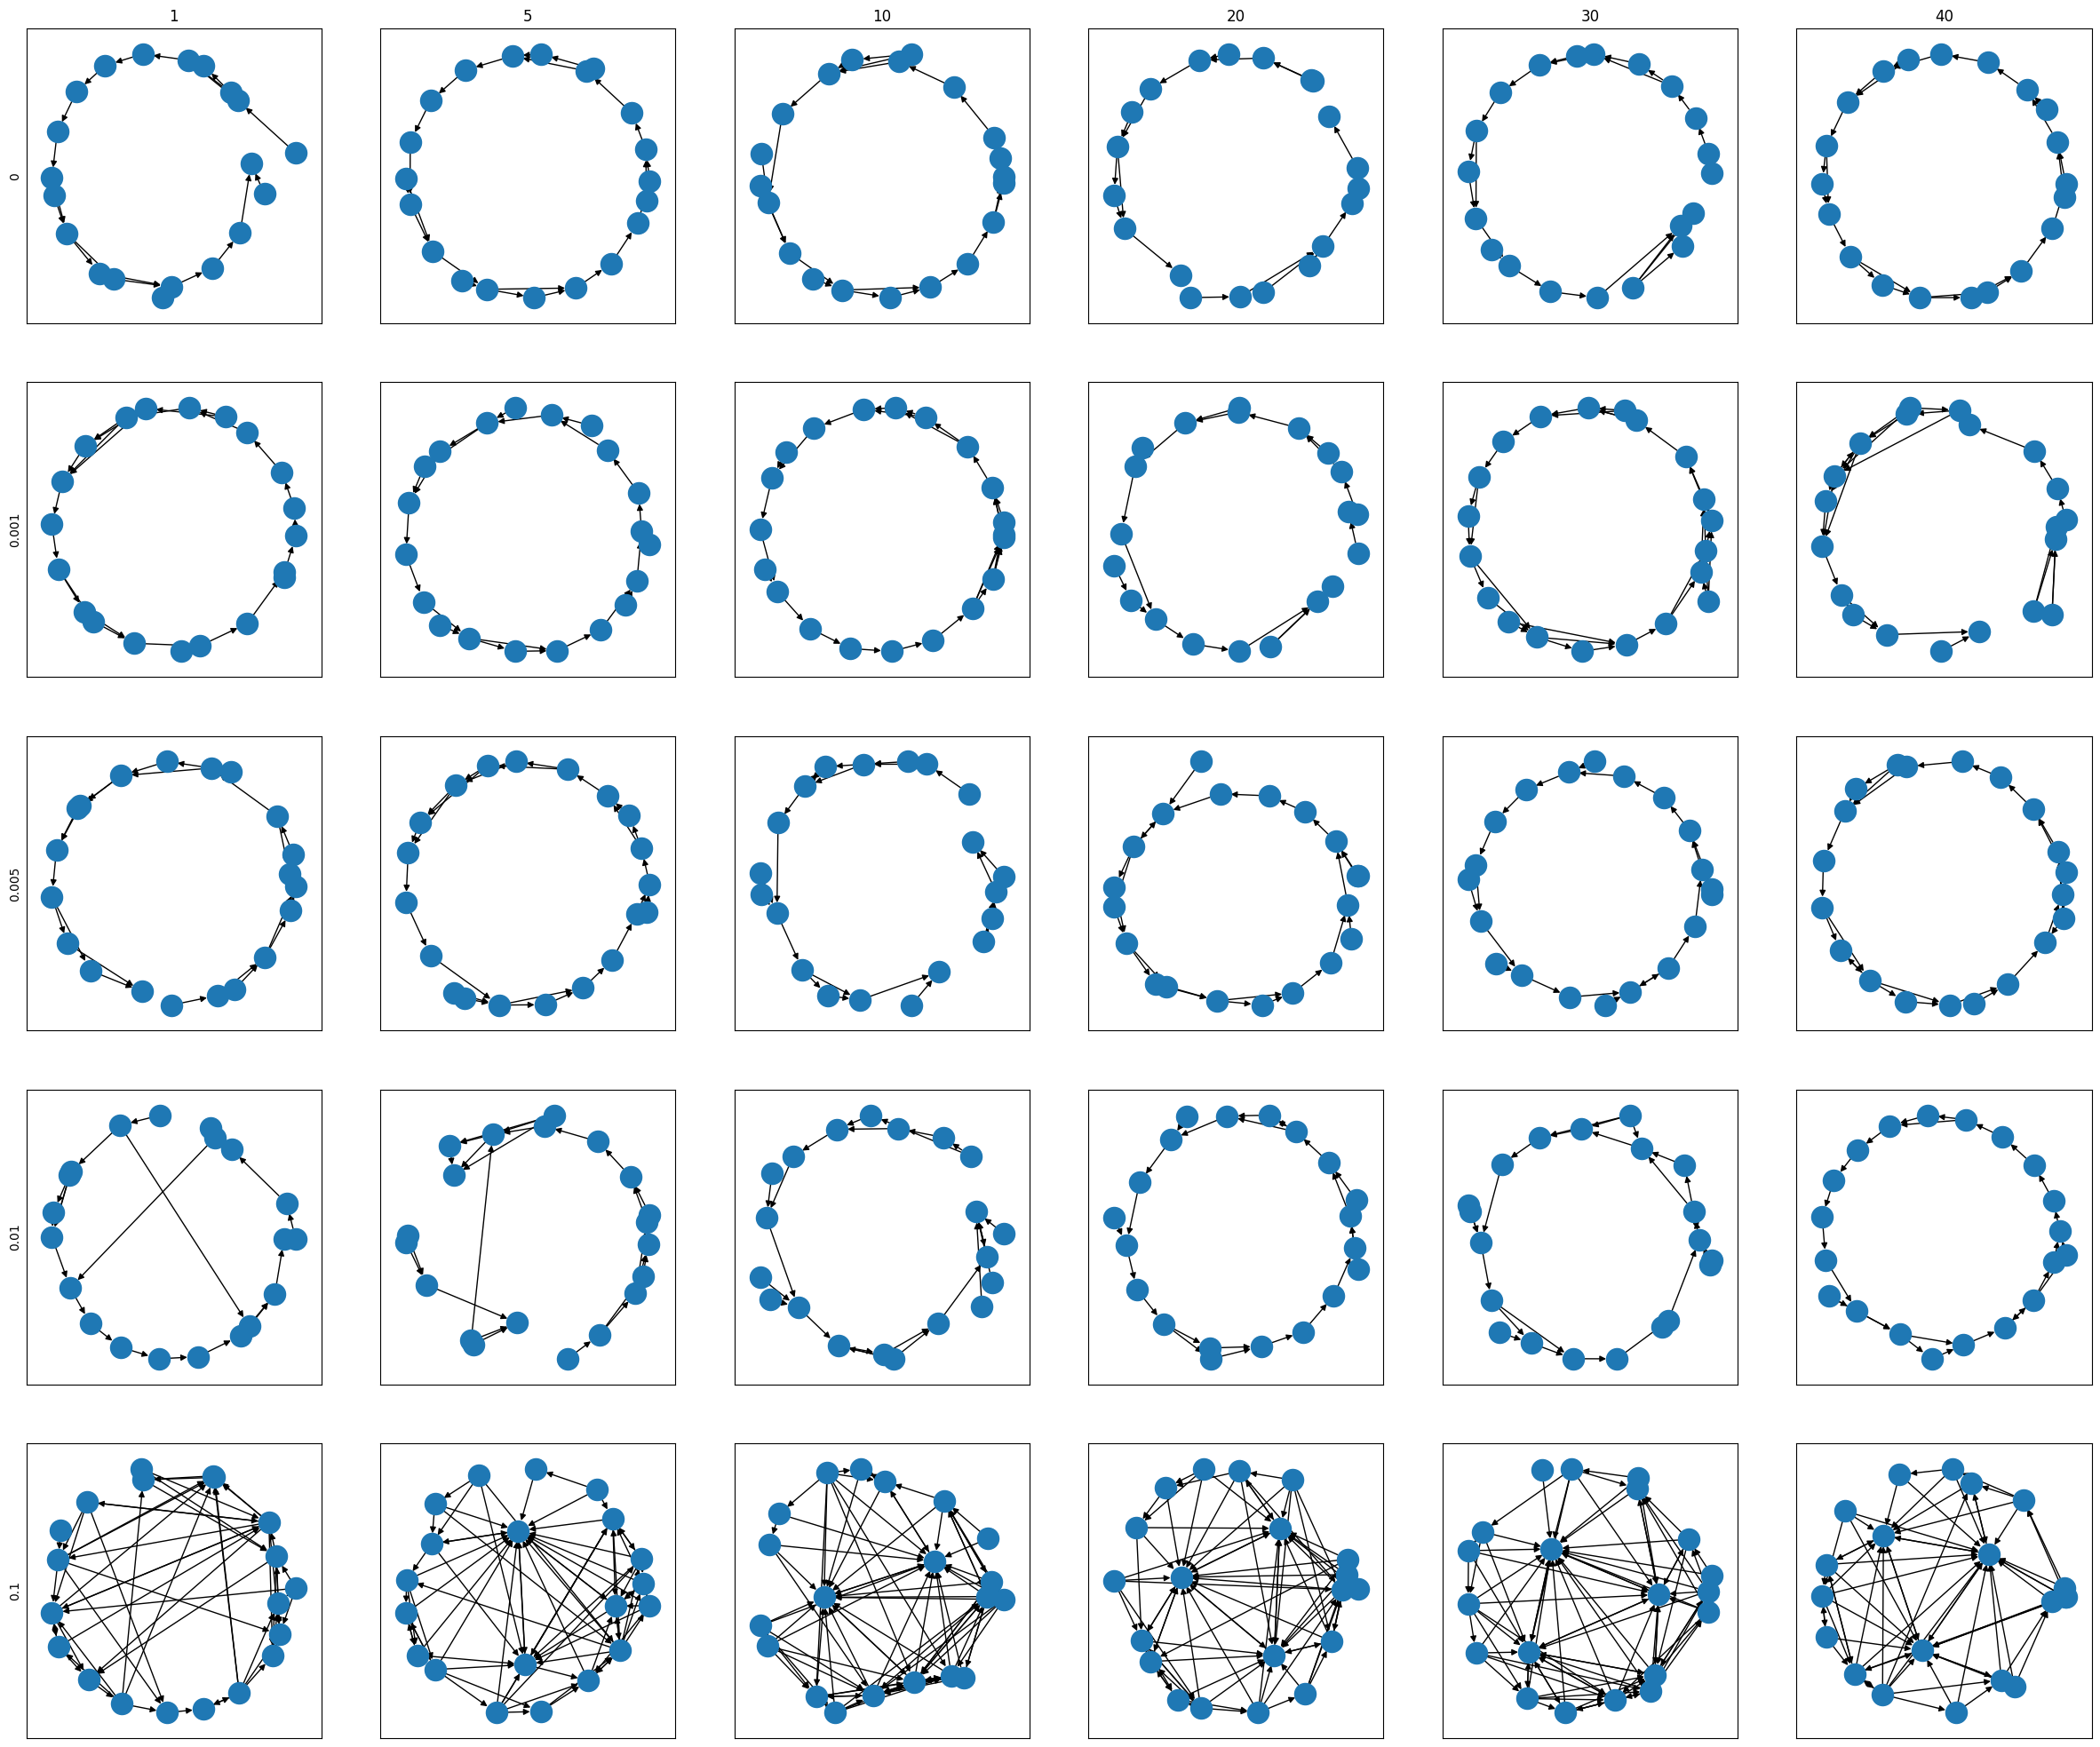

In [135]:
%store -r oriented_grid
do_threshold=True

n_x = len(noise_values)
n_y = len(n_target_parameters)

_, axes = plt.subplots(n_x, n_y, figsize =(n_y*5, n_x*5))



for (i, noise), (j, n_targets) in it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    G = oriented_grid[i][j]
    if do_threshold:    
        markov, labels = G.get()
        G = markov_threshold(markov.numpy(force=True), my_threshold)
        G.remove_edges_from(nx.selfloop_edges(G))
        pos = {i: l.numpy(force=True) for i, l in enumerate(labels)}
        nx.draw(G, pos, ax=axes[i, j])
    else:     
        G.draw(ax=axes[i,j])
    axes[i, j].set_axis_on()
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


### $\epsilon - \delta$ grid

In this part we investigate the action of $\epsilon$ and $\delta$ (resp. the sinkhorn regularization parameter and the discount factor of the discounted WL distance).


In [48]:
new_delta_values = [.1, .25, .5, .9, 1.]
new_epsilon_values = [.001, .05, .1, .5, 1, 5]
new_delta_eps_grid = grid_init(len(new_delta_values), len(new_epsilon_values))

for (delta_i, delta_v), (epsilon_i, epsilon_v) in it.product(enumerate(new_delta_values), enumerate(new_epsilon_values)):
    if new_delta_eps_grid[delta_i][epsilon_i] is not None:
        continue
    if delta_v in delta_values: old_delta_i = delta_values.index(delta_v)
    else: continue
    if epsilon_v in epsilon_values: old_epsilon_i = epsilon_values.index(epsilon_v)
    else: continue
    new_delta_eps_grid[delta_i][epsilon_i] = delta_eps_grid[old_delta_i][old_epsilon_i]

np.asarray(new_delta_eps_grid, dtype=object) == None

array([[ True, False, False,  True, False, False],
       [ True, False, False,  True, False, False],
       [ True, False, False,  True, False, False],
       [ True, False, False,  True, False, False],
       [ True, False, False,  True, False, False]])

In [82]:
np.asarray(new_delta_eps_grid, dtype=object) == None

array([[False, False, False, False, False, False],
       [ True, False, False,  True, False, False],
       [ True, False, False,  True, False, False],
       [ True, False, False,  True, False, False],
       [ True, False, False,  True, False, False]])

In [ ]:
projection_size = target_size = 20
#delta_values = [.1, .25, .5, .9, 1.]
#epsilon_values = [.01, .05, .1, 1, 5]
#delta_eps_grid = grid_init(len(delta_values), len(epsilon_values))
#delta_eps_grid = new_delta_eps_grid
delta_values = new_delta_values
epsilon_values = new_epsilon_values
data_type = "oriented_circle"
n_targets=20
noise=0.01

do_threshold=False

for (delta_i, delta_v), (epsilon_i, epsilon_v) in tqdm(it.product(enumerate(delta_values), enumerate(epsilon_values)), total=len(delta_values)*len(epsilon_values)):
    if delta_eps_grid[delta_i][epsilon_i] is not None:
        continue
    print(delta_i, epsilon_i)
    
    graphs, target_markovs, distributions, target_labels = gen_noisy_oriented_circles(
        n_targets, target_size, noise, doubled_edges=doubled_edges)

    projection, parameter_values, losses = opt_loop_batched(
        target_matrices = target_markovs, 
        projection_size=projection_size,
        n_steps=3000,
        heat=1,
        lr=5e-3,
        weight_decay=0,
        run_name=f"{data_type} - barycenter_delta_eps {delta_v}-{epsilon_v}",
        labels=target_labels,
        wl_parameters = dict(sinkhorn_reg=epsilon_v, delta=delta_v, x_is_sparse=False, y_is_sparse=True),
        device = torch.device("cuda:1"),
    )
    delta_eps_grid[delta_i][epsilon_i] = projection
    %store delta_eps_grid
        


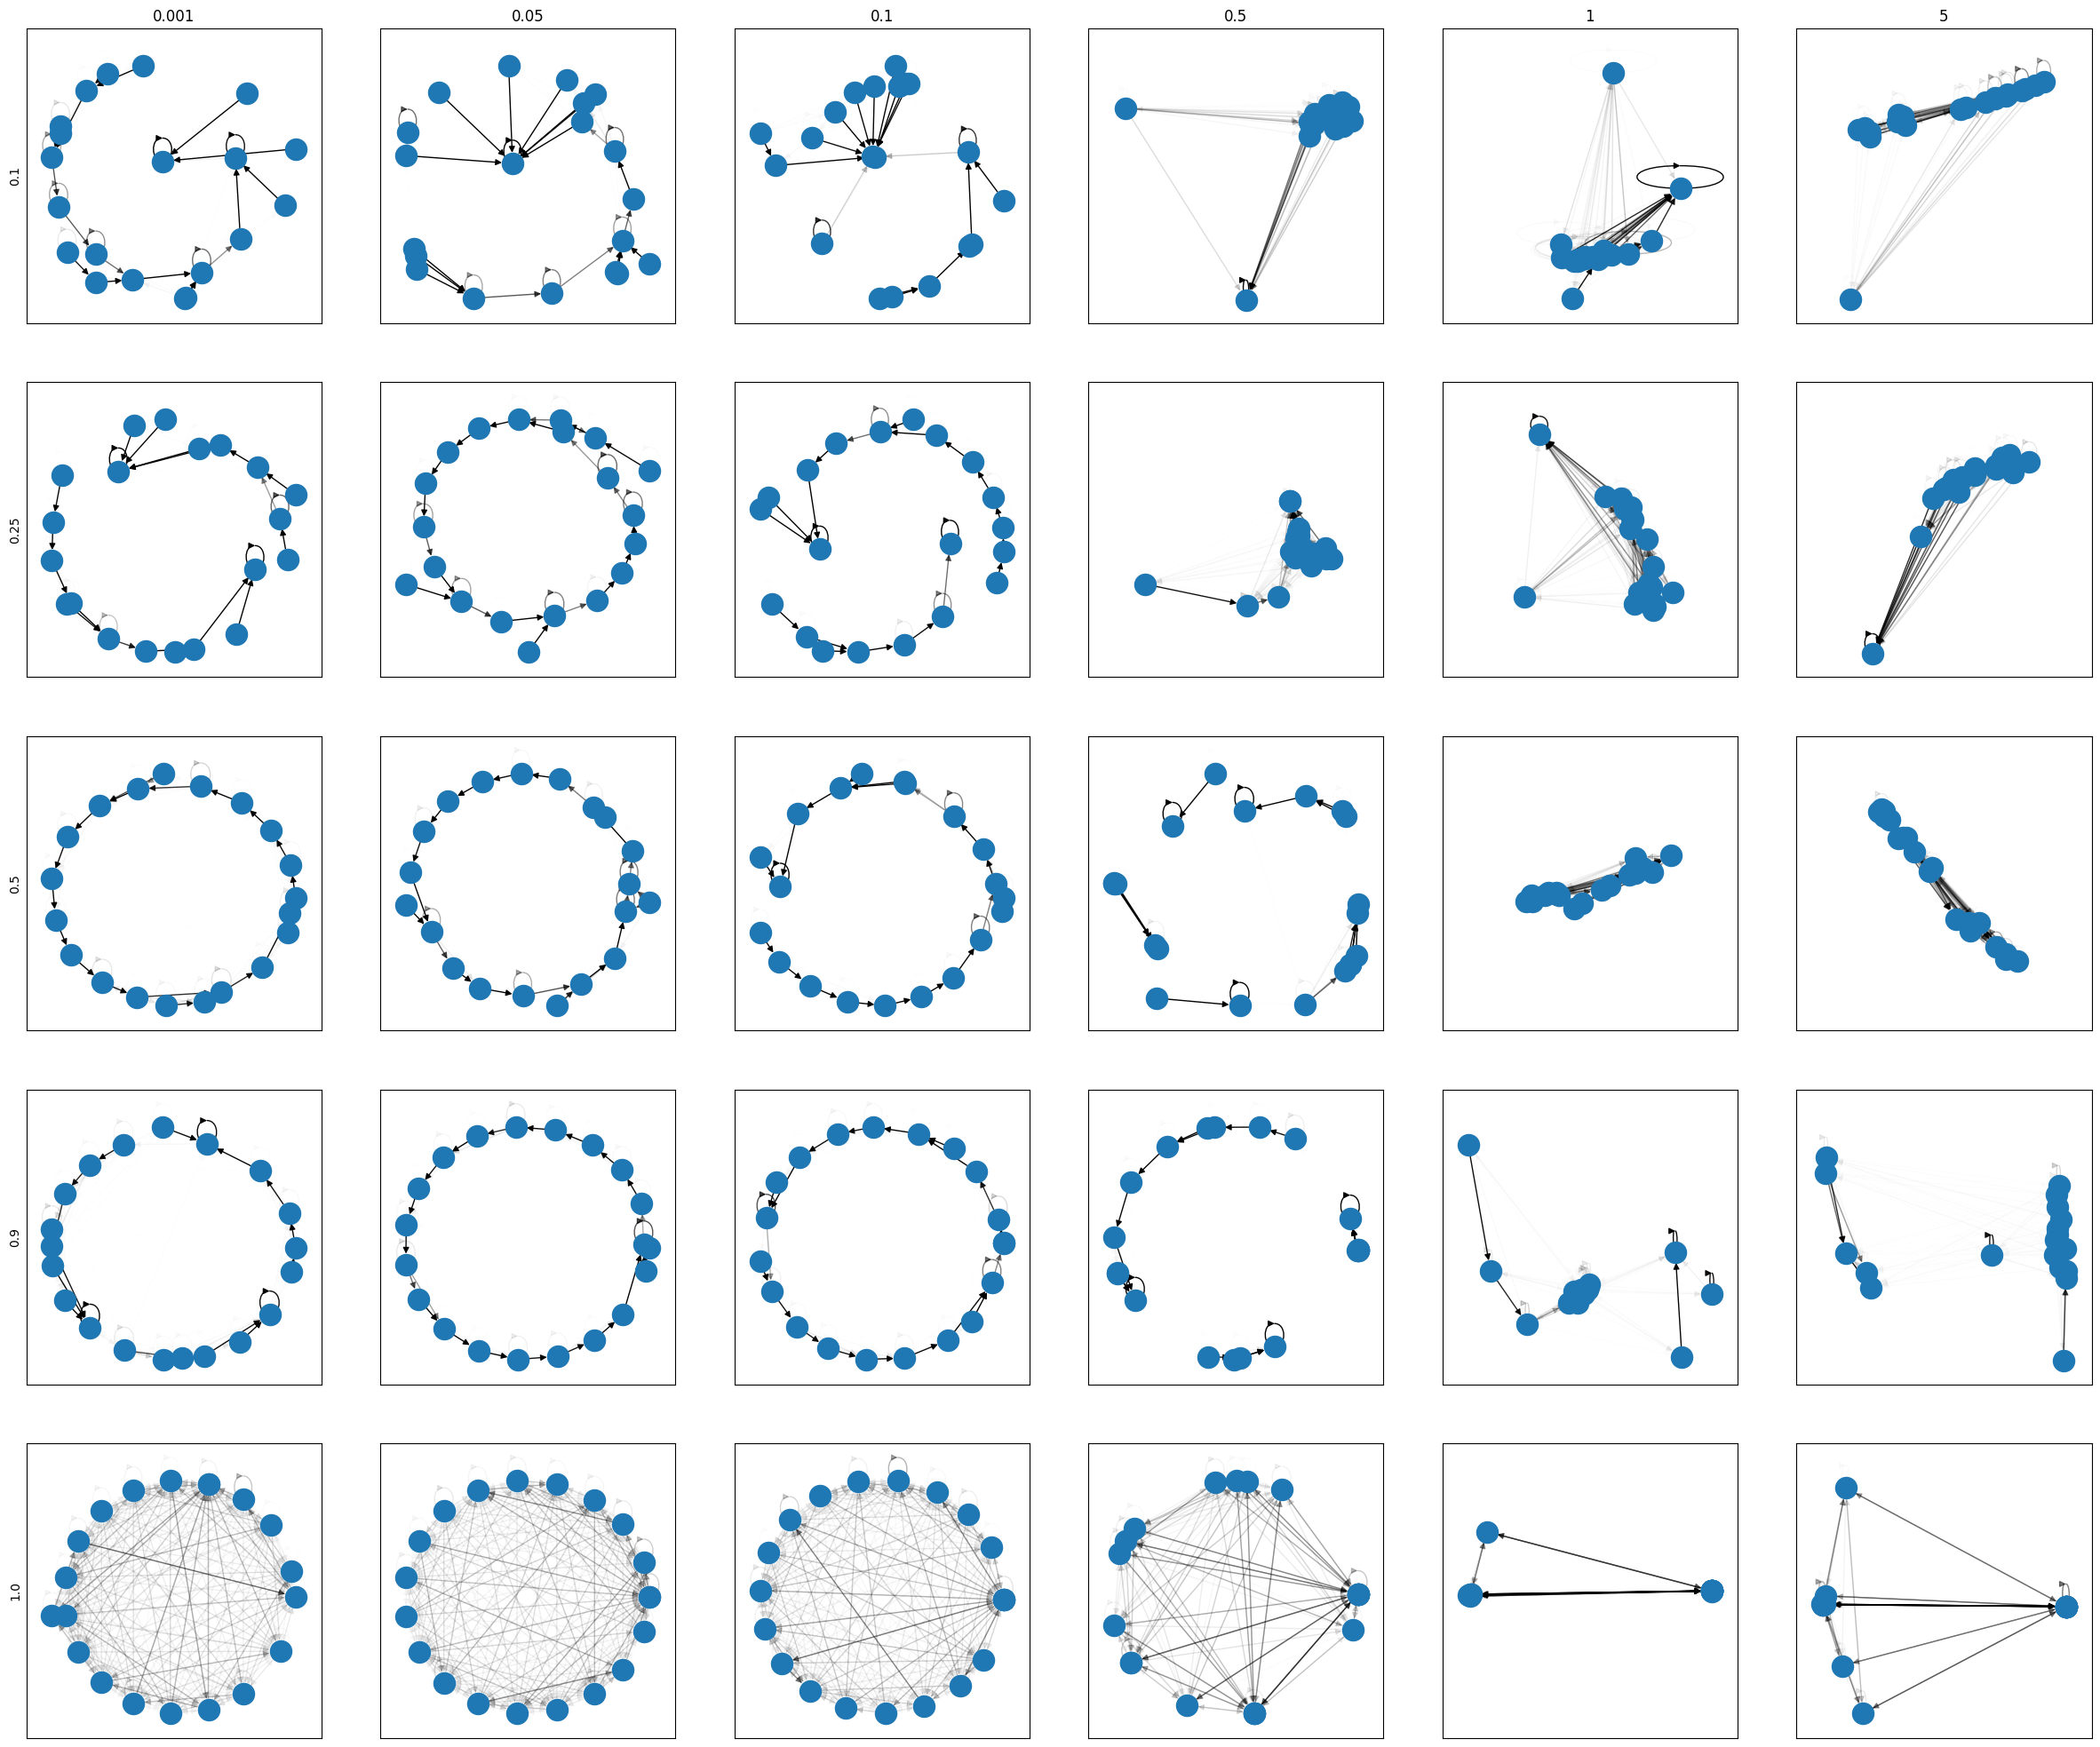

In [85]:
do_threshold=False

n_x = len(delta_values)
n_y = len(epsilon_values)

_, axes = plt.subplots(n_x, n_y, figsize =(n_y*5, n_x*5))



for (i, noise), (j, n_targets) in it.product(enumerate(delta_values), enumerate(epsilon_values)):
    G = delta_eps_grid[i][j]
    if do_threshold:    
        markov, labels = G.get()
        G = markov_threshold(markov.numpy(force=True))
        pos = {i: l.numpy(force=True) for i, l in enumerate(labels)}
        nx.draw(G, pos, ax=axes[i, j])
    else:     
        G.draw(ax=axes[i,j])
    axes[i, j].set_axis_on()
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
